# Inverse Propensity Score

One of the most fundamental feature of _RecoGym_ is the ability to collect logs of applying a specific _`Agent`_ in the _RecoGym_ _`Environment`_. That opens a plethora of opportunities to examine machine learning based on _Counterfactual Risk Minimization_ and compare the result with machine learning based on _Empirical Risk Minimization_.

In _[Likelihood Agents](./Likelihood%20Agents.ipynb)_ notebook, some _Agents_ those use different feature sets for _Liklihood_ model have already been analysed. In this notebook, we consider _Inverse Propensity Score_ that is a part of _Counterfactual Risk Minimization_ approach.

# The Data

In [17]:
import gym, reco_gym
from copy import deepcopy
from reco_gym import env_1_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 4]

ABTestNumberOfUsers = 10000
RandomSeed = 42

NumberOfProducts = 10

NumberOfSamples = 20

env_1_args['random_seed'] = RandomSeed
env_1_args['num_products'] = NumberOfProducts
env_1_args['number_of_flips'] = 1
env_1_args['num_epochs'] = 100


env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [2]:
data = deepcopy(env).generate_logs(ABTestNumberOfUsers)

In [3]:
data[:NumberOfSamples]

,t,u,z,v,a,c,ps,ps-a
0,0,0,organic,0.0,NaN,NaN,NaN,None
1,1,0,bandit,NaN,3.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
2,2,0,bandit,NaN,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
3,3,0,bandit,NaN,5.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
4,0,1,organic,1.0,NaN,NaN,NaN,None
5,1,1,bandit,NaN,2.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
6,2,1,bandit,NaN,8.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
7,3,1,bandit,NaN,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
8,4,1,organic,4.0,NaN,NaN,NaN,None
9,5,1,organic,4.0,NaN,NaN,NaN,None


In [4]:
print("Data Shape:\n", data.shape)

Data Shape:
 (1005241, 8)


Details regarding the content of the data you shall find in _[Likelihood Agents](./Likelihood%20Agents.ipynb)_ notebook.

Please, note that there is a column _**`ps`**_ that is a _Probability Score_ of selecting a particular _`Action`_ by an _`Agent`_. Since the default _`Agent`_ selects an _`Action`_ _**randomly**_ and as there are _`10`_ different _`Actions`_ in overall, the _Probability Score_ is always $\frac{1}{10}$ = _`0.1`_ for all _Bandit_ _`Events`_.

# Multi-Class Classification Models

All models analised below use _Multi-Class Classification_ where for a provided set of features, the models predict an _`Action`_.

That approach differs to what was used in _Logistic Regression_ for _Emirical Risk Minimization_ where an _`Action`_ was a part of input features.

In [5]:
import math
import numpy as np

def build_train_data(
    data,
    weight_history_function = None
):
    """
    Build Train Data

        Parameters:
            data: offline experiment logs
                the data contains both Organic and Bandit Events
            weight_history_function(function): weight functions that assigns an appropriate weight
                for View in Organic Event for a certain Product

        Returns:
            :(features, outs)
    """
    num_products = int(data.v.max() + 1)
    number_of_users = int(data.u.max()) + 1

    features = []
    actions = []
    pss = []
    clicks = []

    for user_id in range(number_of_users):
        views = np.zeros((0, num_products))
        for _, user_datum in data[data['u'] == user_id].iterrows():
            if user_datum['z'] == 'organic':
                assert (math.isnan(user_datum['a']))
                assert (math.isnan(user_datum['c']))
                assert (not math.isnan(user_datum['v']))

                view = int(user_datum['v'])

                tmp_view = np.zeros(num_products)
                tmp_view[view] = 1

                # Append the latest view at the beginning of all views.
                views = np.append(tmp_view[np.newaxis, :], views, axis = 0)
            else:
                assert (user_datum['z'] == 'bandit')
                assert (not math.isnan(user_datum['a']))
                assert (not math.isnan(user_datum['c']))
                assert (math.isnan(user_datum['v']))

                action = int(user_datum['a'])
                click = int(user_datum['c'])
                ps = int(user_datum['ps'])

                if weight_history_function is None:
                    train_views = views
                else:
                    history = np.array(range(views.shape[0])).reshape(views.shape[0], 1)
                    weights = weight_history_function(history)
                    train_views = views * weights

                feature = np.sum(train_views, axis = 0)

                features.append(feature)
                actions.append(action)
                clicks.append(click)
                pss.append(ps)

    return np.array(features), np.array(actions), np.array(clicks), np.array(pss)

## Logistic Regression with Wieghted Training Data

The model is based on _Logistic Regression_ of multiple classes (different _`Actions`_) where during training each feature set will be weighted. The weight for $i^th$ feature set is actually _Inverse Propensity Score_ that is calculated as follows:



$$ w_i \equiv ips_i = \frac{\delta_i}{p_i} $$

* $
\delta_i =
\begin{cases}
    1,& \text{if there is a click}\\
    0,& \text{otherwise}
\end{cases}
$
* $p_i$ is a _Probability Score_ that is for the case of _Random_ _`Agent`_ is _**always**_ _`0.1`_.

In [6]:
train_features01, train_actions01, train_clicks01, train_pss01 = build_train_data(data)

random_ps = 1.0 / NumberOfProducts
train_weights01 = train_clicks01 / random_ps

from sklearn.linear_model import LogisticRegression

logreg_weighted01 = LogisticRegression(
    solver = 'lbfgs',
    max_iter = 5000,
    multi_class='multinomial',
    random_state = RandomSeed
)

lr_weighted01 = logreg_weighted01.fit(train_features01, train_actions01, train_weights01)

In [7]:
lr_weighted01.coef_

array([[ 9.23450582e-03, -1.92230381e-02, -1.69616485e-02,
        -3.50144220e-02, -2.19463784e-03,  1.27838989e-02,
         6.47237516e-03, -2.27299902e-02,  1.23338713e-02,
         5.36722383e-03],
       [ 2.76796273e-03,  3.94768749e-02,  1.32115715e-01,
        -4.12578791e-02,  4.11861110e-03,  3.02446474e-03,
         2.77970182e-02,  7.17477195e-03,  3.54098895e-03,
         1.15469552e-04],
       [-2.02292057e-02,  2.33102171e-03, -2.22781741e-02,
         1.89367372e-02, -3.93938576e-03, -1.03165445e-02,
        -1.96950002e-02, -2.33832556e-03,  6.38422256e-03,
         1.16137571e-03],
       [-1.22286049e-02,  3.61845220e-02, -8.59995018e-02,
         5.02535968e-02,  4.94505568e-03, -1.80168294e-02,
        -1.12800717e-01, -3.46056145e-04, -5.55795519e-04,
         6.62762924e-04],
       [-5.94516224e-03, -8.94700270e-03,  1.48992557e-01,
        -1.43498074e-02,  6.65866499e-03,  5.93991803e-04,
         9.98167489e-03, -8.81541108e-03,  1.74669338e-02,
        -5.

Let's check how the model works if in _`Views`_ thare are _`10`_s for each _`Product`_.

In [8]:
test_views01 = np.zeros((NumberOfProducts, NumberOfProducts))
for product_id in range(NumberOfProducts):
    test_views01[product_id, product_id] = 10
print("Predicted Action: ", lr_weighted01.predict(test_views01))

Predicted Action:  [5 2 4 2 4 5 9 4 4 9]


In [9]:
print("Predicted Probability of Actions: ", lr_weighted01.predict_proba(test_views01))

Predicted Probability of Actions:  [[0.11453887 0.08204144 0.10084504 0.05994912 0.12625679 0.13545741
  0.0727351  0.07746896 0.1063475  0.12435976]
 [0.08652404 0.11891358 0.12688369 0.09768137 0.12302442 0.11376451
  0.09655393 0.06519528 0.06050172 0.11095746]
 [0.05887069 0.19975521 0.06598887 0.01914761 0.39705933 0.02349452
  0.0294064  0.06103884 0.06110938 0.08412915]
 [0.07214771 0.05179308 0.14628183 0.10979432 0.1138136  0.12043266
  0.06347803 0.07848718 0.10316502 0.14060656]
 [0.1022002  0.0831829  0.11872313 0.07120362 0.14326083 0.12608784
  0.06597255 0.0721668  0.10205069 0.11515145]
 [0.11745006 0.08140157 0.11020219 0.05599257 0.13339497 0.14129372
  0.06377079 0.09116382 0.08156461 0.12376571]
 [0.10381988 0.09818756 0.09447088 0.02043276 0.1379582  0.13054035
  0.10271497 0.07875787 0.08304392 0.15007361]
 [0.0841274  0.08669148 0.12194339 0.06826415 0.12404922 0.121152
  0.07325288 0.10452073 0.09867015 0.1173286 ]
 [0.11538718 0.08074855 0.12852259 0.06579933 0

As you can see, only _`Products`_ _`4`_, _`5`_, and _`9`_ correlate with amount of appropriate _`Views`_.

Let's build a graph to reveal the correlation of matched products with the appropriate amount of _`Views`_.

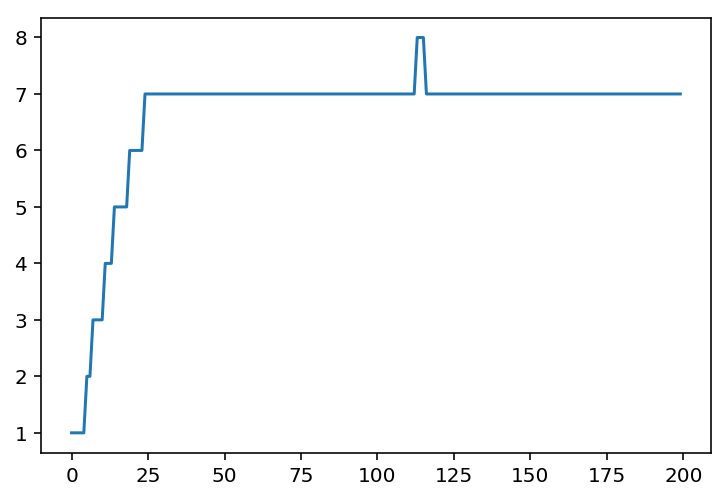

In [10]:
all_product_ids = np.array(range(NumberOfProducts))
inc_matrix = np.eye(NumberOfProducts)
views = np.zeros((NumberOfProducts, NumberOfProducts))
counts = []
matcheses = []
for count in range(200):
    views += inc_matrix
    predictions = lr_weighted01.predict(views)
    matches = np.sum(predictions == all_product_ids)
    matcheses.append(matches)
    counts.append(count)

_, ax = plt.subplots()
ax.plot(counts, matcheses)
plt.show()

Now, we will build a more complex model with product crossfitting.

In [11]:
from sklearn.preprocessing import PolynomialFeatures

logreg_weighted02 = LogisticRegression(
    solver = 'lbfgs',
    max_iter = 10000,
    multi_class='multinomial',
    random_state = RandomSeed
)
poly2 = PolynomialFeatures(2)
lr_weighted02 = logreg_weighted02.fit(poly2.fit_transform(train_features01), train_actions01, train_weights01)

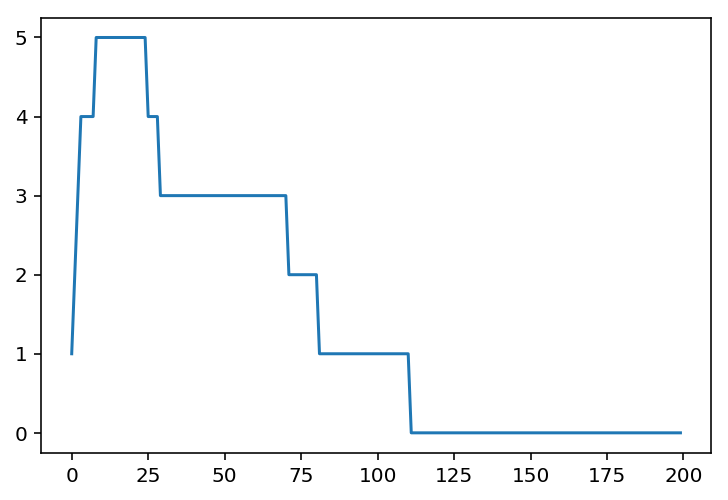

In [12]:
views = np.zeros((NumberOfProducts, NumberOfProducts))
counts = []
matcheses = []
for count in range(200):
    views += inc_matrix
    predictions = lr_weighted02.predict(poly2.fit_transform(views))
    matches = np.sum(predictions == all_product_ids)
    matcheses.append(matches)
    counts.append(count)

_, ax = plt.subplots()
ax.plot(counts, matcheses)
plt.show()

At this moment, it is not clear yet how the model behavies and what kind of performance in _Click-Through Rate_ shall we expect. To reveal that, we bench the _`Agent`_ that uses the model.

## Hypothesis with Inversed Propensity Score

So far, _[scikit-learn](https://scikit-learn.org)_ was used to create models. This time, we are going to build a more complicated model based on a _Neural Network_. The model implements a new hypothesis $h_c(A=a|V)$ that for given _`Views`_ finds _the probability of the click_ for an _`Action`_ $a$. The value of that function is _Probability Score_ that is stored by _RecoGym_ in offline logs.

At this time, we will use _[PyTorch](https://pytorch.org)_ to train models.

$$
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator{\Var}{Var}
\hat{R}^{M}(h_c) = \frac{1}{n} \sum_{i}^{N}\delta_{i} \min \left \{ M, \frac{h_c(A = a_i|V_i)}{p_i} \right \}
$$

$$
u_i = \delta_i \min \left \{ M, \frac{h_c(A = a_i|V_i)}{p_i} \right \}, \bar{u} = \frac{1}{N} \sum_{i}^{N} u_i
$$

$$
\Var_{h_c}(u) = \frac{1}{N - 1} \sum_{i}^{N} \left( u_i - \bar{u} \right)^2
$$

$$
\hat{h}_c^{CRM} = \argmin_{h \in \mathcal{H}} \left \{ \hat{R}^{M}(h_c) + \lambda \sqrt{\frac{\Var_{h_c}(u)}{N}} \right \} 
$$

In the new model, $\hat{h}_c^{CRM}$ is to be minimised, where:
* $\hat{h}_c^{CRM}$ is a new hypothesis that based on _Counterfactual Risk Minimization_
* $N$ is the number of training samples
* $p_i$ is a _Propensity Score_ or a probability of applying the default hypothesis $h_0$; in our case, it is always $\frac{1}{10}=0.1$
* $a_i$ is an _`Action`_ provided in the ith training sample
* $V_i$ _`Views`_ at ith training sample

In the new model, we also use a regularisation defined as: $\lambda \sqrt{\frac{\Var_{h_c}(u)}{N}}$.

The new hypothesis is implemented in a neural network.
The network has the following topology:
* _`2`_ sigmoid layers
* _`1`_ _softmax_ layer

More details about the structure of the NN, you shall find in _`NeuralNet`_ class.

The model used here was motivated by the article _[arXiv:1502.02362](https://arxiv.org/pdf/1502.02362.pdf)_.

## Comparing Agent Performance

Let's compare the performance of models with _IPS & Multi-Class Logistic Regression_ vs _IPS & Hypothesis implemented in Neural Network_.

In [13]:
import gym
import matplotlib.pyplot as plt

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

from reco_gym import build_agent_init, env_1_args, gather_agent_stats, plot_agent_stats

RandomSeed = 42
TrainingDataSamples = (100, 500, 1000, 2000, 3000, 5000, 8000, 10000, 13000, 14000, 15000)
TestingDataSamples = 10000
StatEpochs = 2
StatEpochsNewRandomSeed = True

std_env_args = {
    **env_1_args,
    'random_seed': RandomSeed,
}

env = gym.make('reco-gym-v1')

The code that imports Agents.

In [14]:
from agents import OrganicUserEventCounterAgent, organic_user_count_args
from agents import LogregPolyAgent, logreg_poly_args
from agents import LogregMulticlassIpsAgent, logreg_multiclass_ips_args
from agents import NnIpsAgent, nn_ips_args

Gathering statistics...

In [15]:
agent_stats = gather_agent_stats(
    env,
    std_env_args,
    {
        'num_products': 10,
        'number_of_flips': 5,
    },
    {
        **build_agent_init(
            'Organic Counter (per a User)',
            OrganicUserEventCounterAgent,
            organic_user_count_args
        ),
        **build_agent_init(
            'LogReg Poly',
            LogregPolyAgent,
            {
                **logreg_poly_args,
                'with_ips': False,
            }
        ),
        **build_agent_init(
            'LogReg Poly & IPS',
            LogregPolyAgent,
            {
                **logreg_poly_args,
                'with_ips': True,
            }
        ),
        **build_agent_init(
            'LogReg MC & IPS',
            LogregMulticlassIpsAgent,
            {
                **logreg_multiclass_ips_args,
            }
        ),
        **build_agent_init(
            'Hypothesis NN & IPS',
            NnIpsAgent,
            {
                **nn_ips_args,
            }
        ),
    },
    TrainingDataSamples,
    TestingDataSamples,
    StatEpochs,
    StatEpochsNewRandomSeed
)

Agent: Organic Counter (per a User)
Start: Num of Offline Users: 100
Start: Agent Training #0
Start: Agent Training #1
Start: Agent Testing #0
Start: Agent Testing #1
End: Agent Testing #1 (81.90943694114685s)
End: Agent Testing #0 (96.83746647834778s)
End: Num of Offline Users: 100 (97.38105034828186s)
Start: Num of Offline Users: 500
Start: Agent Training #0
Start: Agent Training #1
Start: Agent Testing #0
Start: Agent Testing #1
End: Agent Testing #0 (85.03580379486084s)
End: Agent Testing #1 (102.1338529586792s)
End: Num of Offline Users: 500 (102.70032000541687s)
Start: Num of Offline Users: 1000
Start: Agent Training #0
Start: Agent Training #1
Start: Agent Testing #0
Start: Agent Testing #1
End: Agent Testing #0 (88.30235505104065s)
End: Agent Testing #1 (104.96529507637024s)
End: Num of Offline Users: 1000 (105.4890148639679s)
Start: Num of Offline Users: 2000
Start: Agent Training #0
Start: Agent Training #1
Start: Agent Testing #0
Start: Agent Testing #1
End: Agent Testing #0

End: Num of Offline Users: 10000 (1352.3484959602356s)
Start: Num of Offline Users: 13000
Start: Agent Training #0
Start: Agent Training #1
Start: Agent Testing #0
Start: Agent Testing #1
End: Agent Testing #1 (1393.1026186943054s)
End: Agent Testing #0 (1405.744598865509s)
End: Num of Offline Users: 13000 (1406.6804604530334s)
Start: Num of Offline Users: 14000
Start: Agent Training #0
Start: Agent Training #1
Start: Agent Testing #1
Start: Agent Testing #0
End: Agent Testing #1 (1419.0902009010315s)
End: Agent Testing #0 (1736.1922512054443s)
End: Num of Offline Users: 14000 (1737.0806477069855s)
Start: Num of Offline Users: 15000
Start: Agent Training #1
Start: Agent Training #0
Start: Agent Testing #1
Start: Agent Testing #0
End: Agent Testing #0 (1419.1515438556671s)
End: Agent Testing #1 (1442.3467211723328s)
End: Num of Offline Users: 15000 (1443.261644601822s)
Agent: LogReg MC & IPS
Start: Num of Offline Users: 100
Start: Agent Training #0
Start: Agent Training #1
Start: Agent 

Plotting results...

<IPython.core.display.Javascript object>


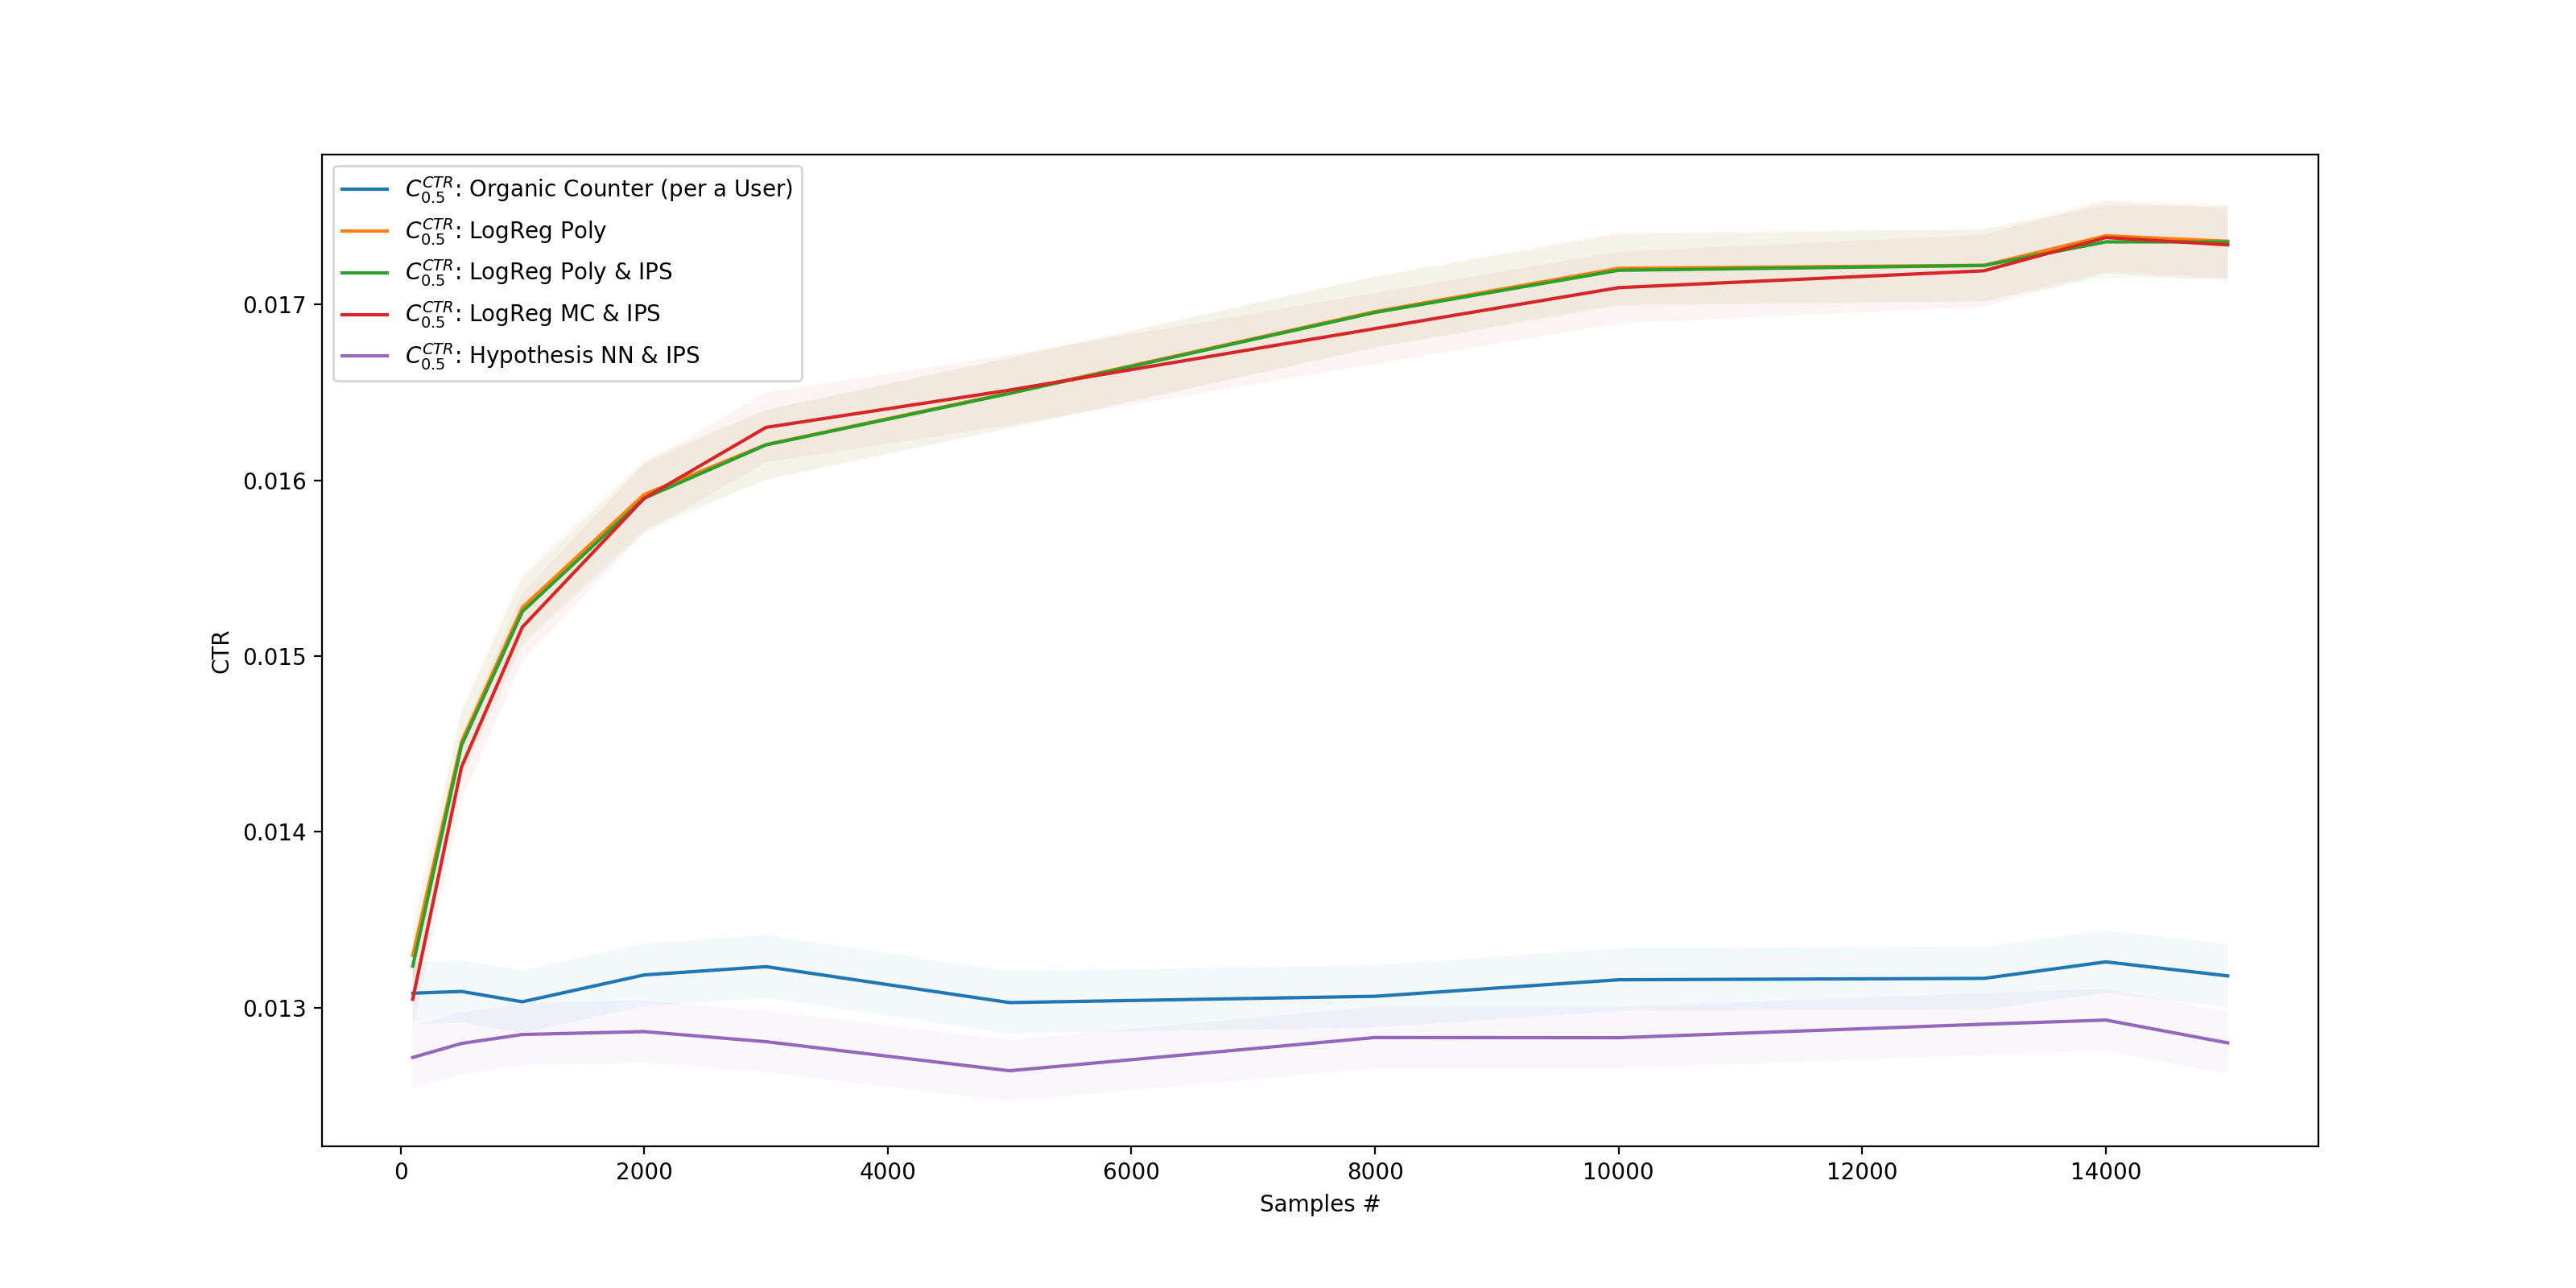

In [16]:
plot_agent_stats(agent_stats)

## Conclusion

In the latest graph, it is evident that _**all**_ models with _IPS_ for _Uniform_ Data Set (the training data obtained after applying so-called _Random_ _`Agent`_) do _**not**_ outperform _Logistic Regression_ _**without**_ _IPS_.

The only difference is _Logistic Regression_ with _Multi-Class_ classification (based on _IPS_). That model behaves almost similarly to _Logistic Regression_ with a polynomial feature set.